In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
import wandb
from wandb.fastai import WandbCallback

In [3]:
WANDB_NOTEBOOK_NAME="Spacenet"

In [4]:
wandb.init(project="spacenet_buildings", name = 'lets_run_big')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/pexwum8i

In [5]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, input, target):
        input = torch.sigmoid(input)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(input, target)
        dice_val = self.dice_loss(input, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, input, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = input[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss
    
    

# class CE_DiceLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.ce = nn.BCELoss()

#     def forward(self,inputs,targets):
#         inputs = torch.sigmoid(inputs)
#         targets = targets.type(torch.FloatTensor).cuda()
#         ce_loss = self.ce(inputs,targets)
#         dice = self.dice_loss(inputs,targets)
#         return ce_loss + dice

#     def dice_loss(self,input, target):
#         smooth = 1.
#         bs = target.shape[0]
#         m1 = input.view(bs, -1).contiguous()
#         m2 = target.view(bs, -1).contiguous()
#         intersection = (m1 * m2)

#         score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
#         score = 1 - score.sum() / bs
#         return score

In [6]:
path = Path("/home/ubuntu/Kharbanda/Buildings")

In [7]:
path_img = path/'Images'
path_mask = path/'Masks'

In [8]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[:5]) == "3band"]
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img5750.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6415.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img600.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6329.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img435.tif')]

In [9]:
len(fname)

6940

In [10]:
img = open_image(fname[9])
img.show(figsize=(10,10))

In [11]:
string = 'Images/'
data = [string + x.name for x in fname]

v1_df = pd.DataFrame(data, columns = ['Images'])
v1_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img6415.tif
2,Images/3band_AOI_1_RIO_img600.tif
3,Images/3band_AOI_1_RIO_img6329.tif
4,Images/3band_AOI_1_RIO_img435.tif


In [8]:
rio_df = pd.read_csv(path/'rio_df.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img6891.tif
1,Images/3band_AOI_1_RIO_img6892.tif
2,Images/3band_AOI_1_RIO_img6895.tif
3,Images/3band_AOI_1_RIO_img6894.tif
4,Images/3band_AOI_1_RIO_img6899.tif


In [9]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [10]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.15).
      label_from_func(get_y_fn, classes=codes))

In [12]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15.0, max_zoom=1.5, max_lighting = 0.4), size = size, tfm_y=True).
       databunch(bs=bs).normalize())

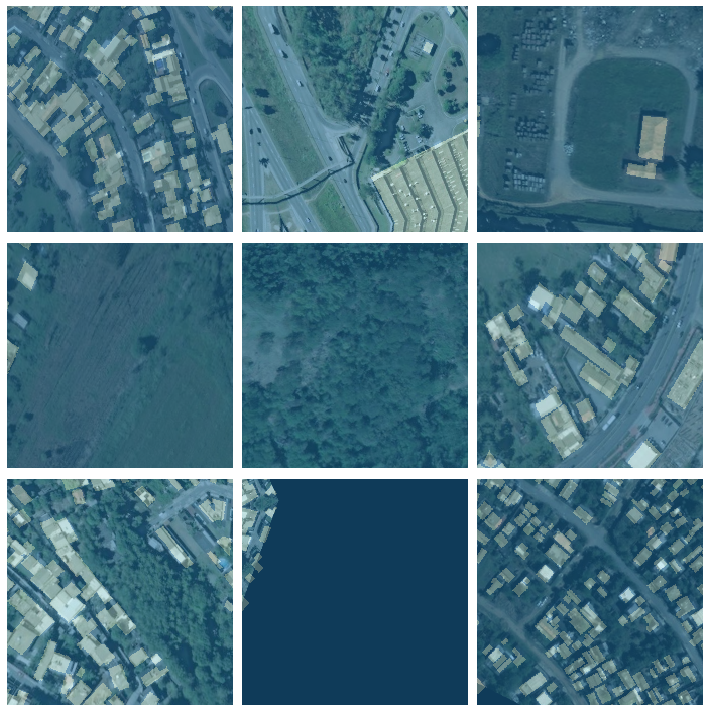

In [20]:
data.show_batch(3, figsize=(10,10))

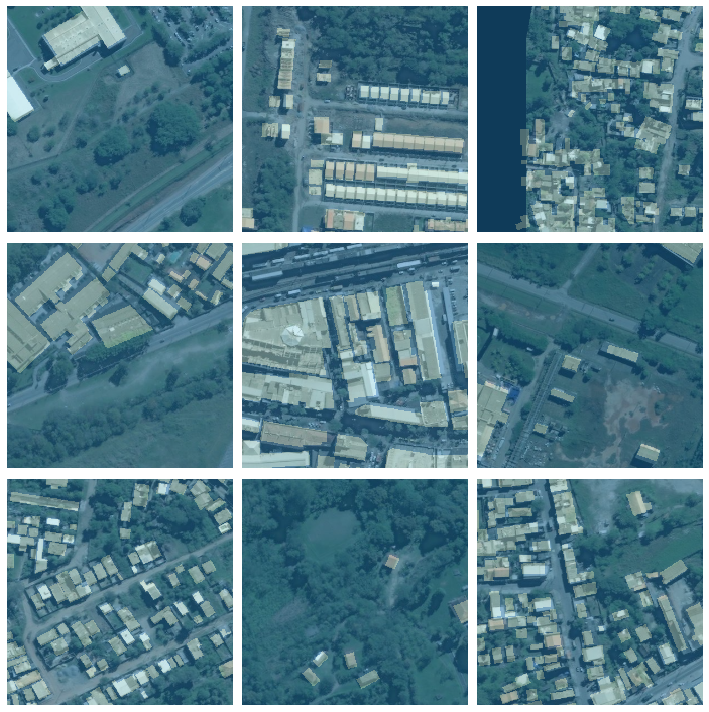

In [22]:
data.show_batch(3, figsize=(10,10),  ds_type=DatasetType.Valid)

In [13]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    callback_fns=partial(WandbCallback, input_type='images'))
learn.loss = CE_DiceLoss
# learn.loss = L1Loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


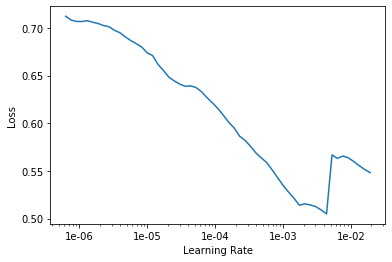

In [11]:
learn.lr_find()
learn.recorder.plot() #Dice

In [12]:
#lr = 3e-3#

In [13]:
lr = 1e-3

In [14]:
%wandb
learn.fit_one_cycle(10, slice(lr), pct_start = 0.7) #CE+Dice

epoch,train_loss,valid_loss,dice,time
0,0.271731,0.238267,0.301136,00:55
1,0.230895,0.205869,0.487524,00:47
2,0.214239,0.195632,0.511401,00:47
3,0.206506,0.193427,0.483988,00:47
4,0.202343,0.183920,0.554981,00:47
5,0.193278,0.181559,0.506146,00:47
6,0.192426,0.181540,0.553475,00:47
7,0.184699,0.171710,0.546138,00:47
8,0.177160,0.170912,0.555355,00:47
9,0.175168,0.169082,0.562743,00:47


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 0 with valid_loss value: 0.23826740682125092.
Better model found at epoch 1 with valid_loss value: 0.20586945116519928.
Better model found at epoch 2 with valid_loss value: 0.19563153386116028.
Better model found at epoch 3 with valid_loss value: 0.1934267282485962.
Better model found at epoch 4 with valid_loss value: 0.1839195340871811.
Better model found at epoch 5 with valid_loss value: 0.1815585047006607.
Better model found at epoch 6 with valid_loss value: 0.18153981864452362.
Better model found at epoch 7 with valid_loss value: 0.17170962691307068.
Better model found at epoch 8 with valid_loss value: 0.17091190814971924.
Better model found at epoch 9 with valid_loss value: 0.16908153891563416.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_094606-24vu7e7z/bestmodel.pth


In [19]:
learn.save("F-1-smol-CED")

In [15]:
%wandb

learn.fit_one_cycle(10, slice(lr), pct_start = 0.75) #dice

epoch,train_loss,valid_loss,dice,time
0,0.174626,0.168247,0.561120,00:47
1,0.170695,0.167608,0.557299,00:47
2,0.176387,0.174149,0.575518,00:47
3,0.179210,0.170153,0.556049,00:47
4,0.179309,0.180958,0.566177,00:47
5,0.180892,0.172446,0.574151,00:47
6,0.179313,0.169561,0.563498,00:47
7,0.176494,0.170646,0.553498,00:47
8,0.173907,0.164434,0.578365,00:47
9,0.168591,0.163439,0.578703,00:47


Better model found at epoch 0 with valid_loss value: 0.16824689507484436.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 1 with valid_loss value: 0.16760802268981934.
Better model found at epoch 8 with valid_loss value: 0.16443443298339844.
Better model found at epoch 9 with valid_loss value: 0.16343891620635986.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_094606-24vu7e7z/bestmodel.pth


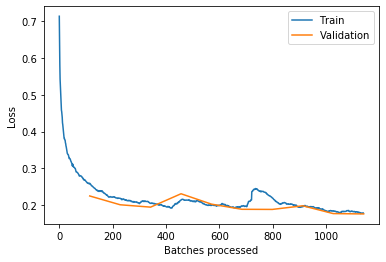

In [16]:
learn.recorder.plot_losses()

In [19]:
%wandb
learn.fit_one_cycle(10, slice(lr/100, lr/10), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.166140,0.163411,0.579485,00:46
1,0.165248,0.163221,0.576489,00:47
2,0.165005,0.163167,0.578492,00:47
3,0.165657,0.164192,0.585424,00:47
4,0.167793,0.163571,0.575812,00:47
5,0.166288,0.162813,0.573703,00:47
6,0.164533,0.162510,0.580793,00:47
7,0.165257,0.162526,0.587513,00:46
8,0.167595,0.162293,0.584399,00:46
9,0.164499,0.162068,0.584320,00:47


Better model found at epoch 0 with valid_loss value: 0.1634110063314438.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 1 with valid_loss value: 0.1632213592529297.
Better model found at epoch 2 with valid_loss value: 0.16316653788089752.
Better model found at epoch 5 with valid_loss value: 0.16281349956989288.
Better model found at epoch 6 with valid_loss value: 0.16250963509082794.
Better model found at epoch 8 with valid_loss value: 0.16229312121868134.
Better model found at epoch 9 with valid_loss value: 0.1620684564113617.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_094606-24vu7e7z/bestmodel.pth


In [20]:
learn.save("F-2-smol-CED")

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


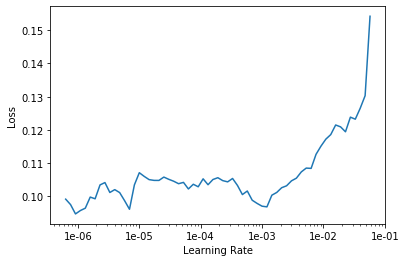

In [0]:
learn.lr_find()
learn.recorder.plot()

In [22]:
%wandb
learn.fit_one_cycle(10, slice(1e-4, 1e-5), pct_start = 0.8)

epoch,train_loss,valid_loss,dice,time
0,0.164954,0.161874,0.582760,00:49
1,0.166307,0.161961,0.583334,00:49
2,0.164215,0.162259,0.583412,00:49
3,0.165041,0.163616,0.580629,00:48
4,0.164484,0.162384,0.580586,00:49
5,0.167305,0.162984,0.579628,00:49
6,0.163867,0.163049,0.581282,00:49
7,0.166366,0.163030,0.582035,00:49
8,0.167568,0.163429,0.582443,00:49
9,0.166002,0.163168,0.581437,00:49


Better model found at epoch 0 with valid_loss value: 0.1618737429380417.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_094606-24vu7e7z/bestmodel.pth


In [23]:
learn.save("UF-1-smol")

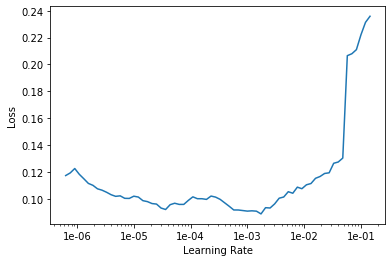

In [0]:
learn.lr_find()
learn.recorder.plot()

In [24]:
%wandb
learn.fit_one_cycle(12, slice(1e-6, 5e-5), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.166858,0.161693,0.581399,00:49
1,0.164740,0.162512,0.585519,00:49
2,0.164240,0.161984,0.583151,00:49
3,0.165198,0.161875,0.584485,00:49
4,0.165576,0.162001,0.581481,00:49
5,0.164333,0.162021,0.581628,00:49
6,0.168155,0.161749,0.584871,00:49
7,0.164233,0.161780,0.586552,00:49
8,0.165994,0.163026,0.588823,00:49
9,0.161568,0.162176,0.585938,00:49


Better model found at epoch 0 with valid_loss value: 0.16169309616088867.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 10 with valid_loss value: 0.16114604473114014.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_094606-24vu7e7z/bestmodel.pth


In [25]:
learn.save("UF-2-smol")

In [14]:
learn.load("UF-2-smol")

Learner(data=ImageDataBunch;

Train: LabelList (3662 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/ubuntu/Kharbanda/Buildings;

Valid: LabelList (646 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /home/ubuntu/Kharbanda/Buildings;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [15]:
size = 406
bs = 16
data = (src.transform(get_transforms(), size = size, tfm_y=True).
       databunch(bs=bs).normalize())

In [16]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


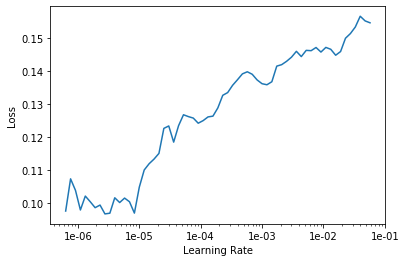

In [0]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.85)

epoch,train_loss,valid_loss,dice,time
0,0.167172,0.157506,0.582199,02:52
1,0.165243,0.153894,0.589180,02:40
2,0.168135,0.153572,0.597458,02:40
3,0.163076,0.150850,0.592935,02:40
4,0.161484,0.149908,0.596194,02:40
5,0.160062,0.149908,0.604139,02:40
6,0.160650,0.149249,0.601965,02:40
7,0.157035,0.149023,0.598111,02:40
8,0.157316,0.147017,0.599872,02:40
9,0.157140,0.147343,0.606885,02:40


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 0 with valid_loss value: 0.15750551223754883.
Better model found at epoch 1 with valid_loss value: 0.15389420092105865.
Better model found at epoch 2 with valid_loss value: 0.15357215702533722.
Better model found at epoch 3 with valid_loss value: 0.15085002779960632.
Better model found at epoch 4 with valid_loss value: 0.14990775287151337.
Better model found at epoch 5 with valid_loss value: 0.14990760385990143.
Better model found at epoch 6 with valid_loss value: 0.1492488533258438.
Better model found at epoch 7 with valid_loss value: 0.14902305603027344.
Better model found at epoch 8 with valid_loss value: 0.1470174491405487.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_130321-pexwum8i/bestmodel.pth


In [18]:
learn.save("F-1-big")

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


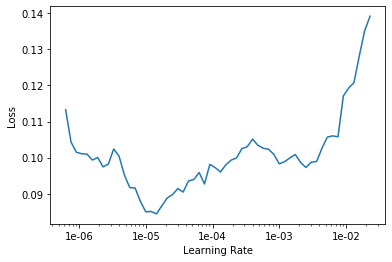

In [0]:
learn.lr_find()
learn.recorder.plot()

In [20]:
%wandb
learn.fit_one_cycle(10, slice(5e-6, 5e-4), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.157714,0.147348,0.606886,02:47
1,0.161301,0.147801,0.605181,02:46
2,0.154309,0.149671,0.610422,02:46
3,0.153411,0.148378,0.610664,02:46
4,0.163775,0.148728,0.592284,02:46
5,0.161992,0.147842,0.609427,02:46
6,0.153482,0.150084,0.611257,02:46
7,0.160457,0.147610,0.611488,02:46
8,0.156836,0.152312,0.615245,02:46
9,0.154165,0.145477,0.614437,02:46


Better model found at epoch 0 with valid_loss value: 0.14734824001789093.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 9 with valid_loss value: 0.1454770416021347.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_130321-pexwum8i/bestmodel.pth


In [21]:
learn.save("UF-1-big")

In [27]:
learn.load("UF-1-big")

Learner(data=ImageDataBunch;

Train: LabelList (3662 items)
x: SegmentationItemList
Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406)
y: SegmentationLabelList
ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406)
Path: /home/ubuntu/Kharbanda/Buildings;

Valid: LabelList (646 items)
x: SegmentationItemList
Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406),Image (3, 406, 406)
y: SegmentationLabelList
ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406),ImageSegment (1, 406, 406)
Path: /home/ubuntu/Kharbanda/Buildings;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [28]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.152348,0.145385,0.614331,02:46
1,0.148957,0.145142,0.613297,02:46
2,0.147652,0.145232,0.613608,02:46
3,0.152013,0.145259,0.614372,02:46
4,0.154305,0.144957,0.614888,02:46
5,0.146996,0.145082,0.613843,02:46
6,0.150573,0.144949,0.612101,02:47
7,0.149388,0.145021,0.612313,02:46
8,0.147858,0.144931,0.613366,02:47
9,0.150649,0.144984,0.613576,02:47


Better model found at epoch 0 with valid_loss value: 0.14538529515266418.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 1 with valid_loss value: 0.14514204859733582.
Better model found at epoch 4 with valid_loss value: 0.14495687186717987.
Better model found at epoch 6 with valid_loss value: 0.14494894444942474.
Better model found at epoch 8 with valid_loss value: 0.14493149518966675.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_153723-ertecl8c/bestmodel.pth


In [29]:
%wandb
learn.fit_one_cycle(10, slice(1e-7, 5e-6), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.149699,0.144963,0.613705,02:46
1,0.155497,0.144986,0.614327,02:47
2,0.147816,0.145099,0.613926,02:47
3,0.152340,0.145024,0.614847,02:47
4,0.153055,0.144906,0.614009,02:47
5,0.147835,0.145097,0.615574,02:47
6,0.146013,0.145136,0.614115,02:47
7,0.149004,0.145048,0.614273,02:47
8,0.148096,0.144939,0.613939,02:47
9,0.153039,0.144825,0.613740,02:47


Better model found at epoch 0 with valid_loss value: 0.14496275782585144.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Better model found at epoch 4 with valid_loss value: 0.14490647614002228.
Better model found at epoch 9 with valid_loss value: 0.14482511579990387.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_153723-ertecl8c/bestmodel.pth


In [30]:
learn.save("UF-2-big")

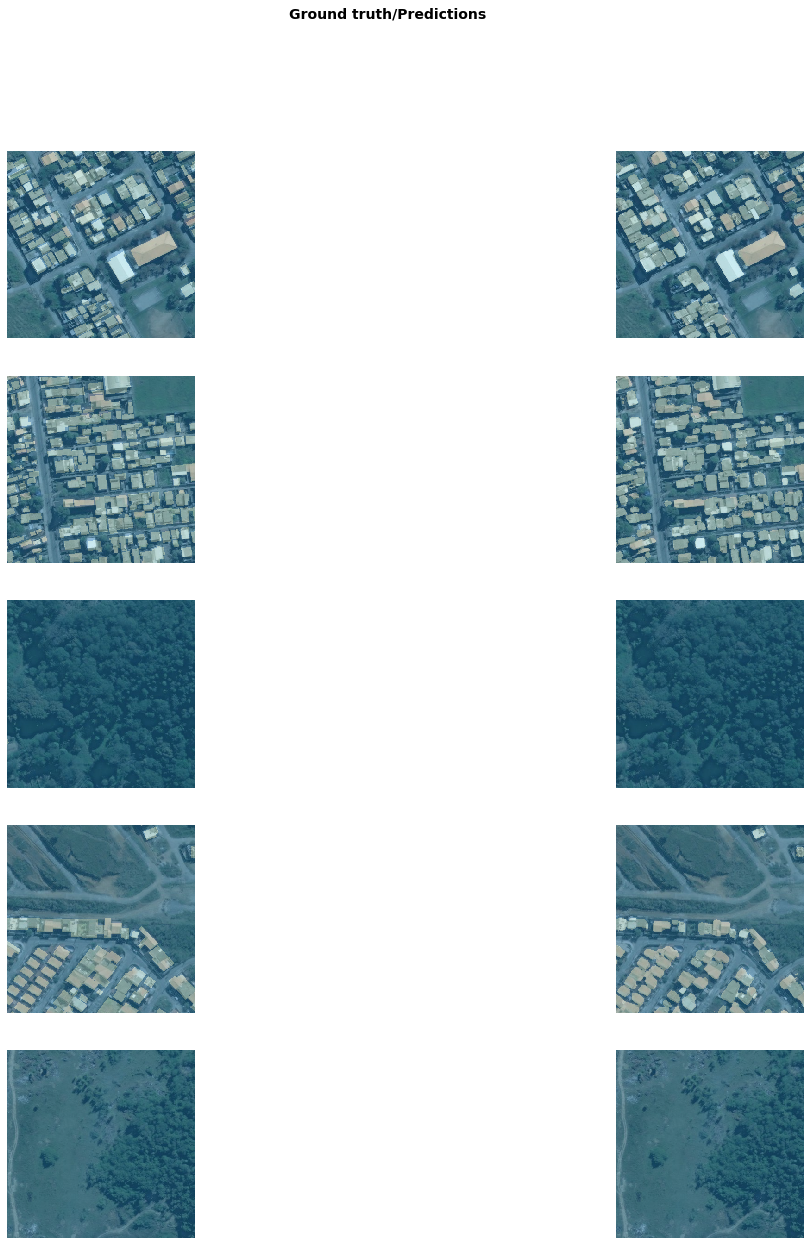

In [0]:
learn.show_results(rows = 5, figsize=(20,20))

In [31]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.145054,0.146398,0.617855,02:47
1,0.147918,0.146449,0.618129,02:47
2,0.146616,0.148491,0.610756,02:47
3,0.153914,0.147609,0.602392,02:47
4,0.151791,0.147715,0.597070,02:47
5,0.155194,0.148569,0.612099,02:47
6,0.161164,0.153718,0.611138,02:47
7,0.157879,0.158762,0.607870,02:47
8,0.152414,0.147233,0.608906,02:47
9,0.151436,0.147226,0.611502,02:47


Better model found at epoch 0 with valid_loss value: 0.14639751613140106.


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20191215_153723-ertecl8c/bestmodel.pth


In [0]:
learn.save("UF-5-big")

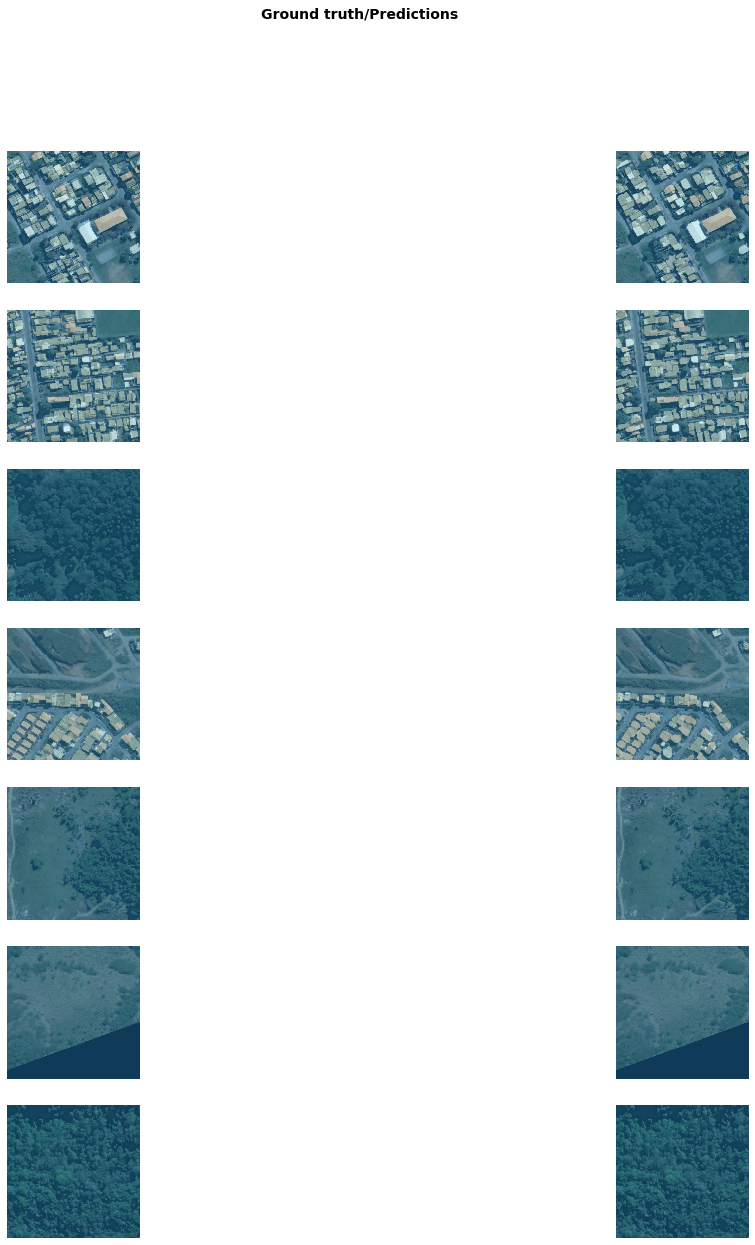

In [0]:
learn.show_results(rows=7, figsize=(20,20))

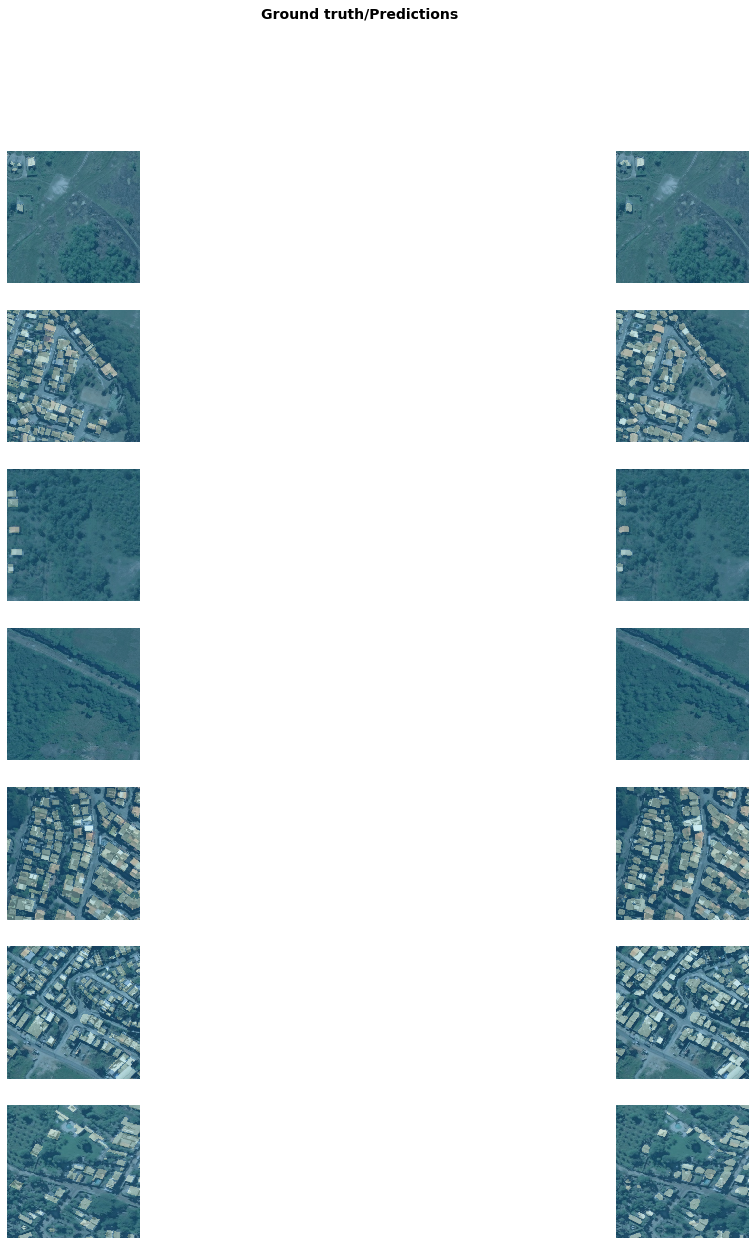

In [0]:
learn.show_results(ds_type=DatasetType.Train, rows=7, figsize=(20,20))

In [0]:
learn.load("UF-5-big")

In [0]:
k = learn.predict(img)

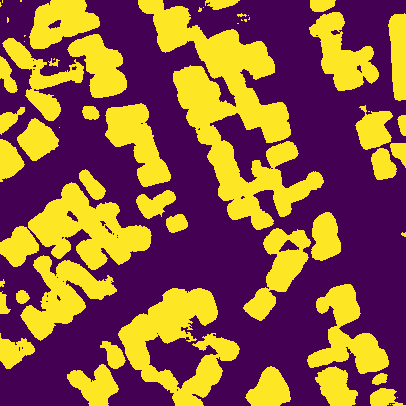

In [0]:
k[0]

In [0]:
e